## table of content
* <a href="#modules">importing modules</a>
* <a href="#visualization">data visualization and preprocessing</a>
* <a href="#pipeline">Building Pipelines</a>
* <a href="#Regression">Regression Models</a>

<a id='modules'></a>
# importing modules and dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder,OneHotEncoder, FunctionTransformer, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.linear_model import LinearRegression, Ridge, Lasso, SGDRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import mean_squared_error

In [2]:
df = pd.read_csv('datasets/blackFriday/train.csv')
df.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 12 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   User_ID                     550068 non-null  int64  
 1   Product_ID                  550068 non-null  object 
 2   Gender                      550068 non-null  object 
 3   Age                         550068 non-null  object 
 4   Occupation                  550068 non-null  int64  
 5   City_Category               550068 non-null  object 
 6   Stay_In_Current_City_Years  550068 non-null  object 
 7   Marital_Status              550068 non-null  int64  
 8   Product_Category_1          550068 non-null  int64  
 9   Product_Category_2          376430 non-null  float64
 10  Product_Category_3          166821 non-null  float64
 11  Purchase                    550068 non-null  int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 50.4+ MB


In [8]:
for i in df.columns:
    print(i, "\t", (df[i].isnull().sum() / len(df)) * 100)

User_ID 	 0.0
Product_ID 	 0.0
Gender 	 0.0
Age 	 0.0
Occupation 	 0.0
City_Category 	 0.0
Stay_In_Current_City_Years 	 0.0
Marital_Status 	 0.0
Product_Category_1 	 0.0
Product_Category_2 	 31.56664266963357
Product_Category_3 	 69.67265865311198
Purchase 	 0.0


<a id='visualization'></a>
# Data visualization and preprocessing

In [10]:
df['Product_Category_2'].unique()

array([nan,  6., 14.,  2.,  8., 15., 16., 11.,  5.,  3.,  4., 12.,  9.,
       10., 17., 13.,  7., 18.])

### both the columns have large amount of missing values, they indicate that the customer didn't but product from these categories.
### so we can fill them with -2 so that the algorithm understands it's missing values and also we don't loose large amount of data

In [168]:
df['Product_Category_2'].fillna(-2, inplace=True)
df['Product_Category_3'].fillna(-2, inplace=True)

<AxesSubplot:xlabel='Age', ylabel='Purchase'>

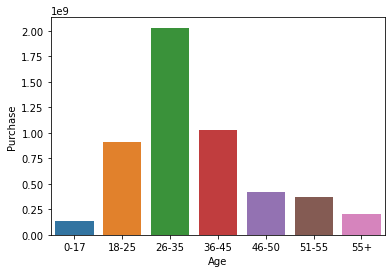

In [25]:
data = df.groupby(df['Age'])['Purchase'].sum().reset_index()
sns.barplot(x = data['Age'], y = data['Purchase'])

### age group 26-35 has maximum spending, next we'll see the products purchased commonly by these age groups

<AxesSubplot:xlabel='Product_Category_1', ylabel='count'>

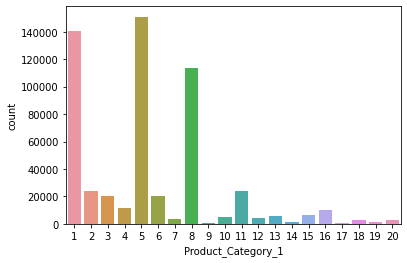

In [32]:
sns.countplot(x = df['Product_Category_1'])

### product 5, 1 and 8 from product category 1 are purchased commonly, let's see the distribution according to age category

<AxesSubplot:xlabel='Age', ylabel='count'>

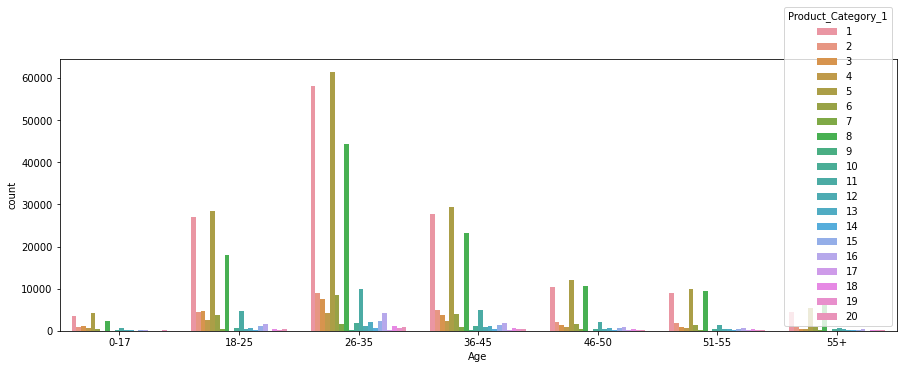

In [38]:
plt.subplots(figsize=(15,5))
data = df.groupby(['Age', 'Product_Category_1'])['Product_Category_1'].count().reset_index(name='count')
sns.barplot(x = data['Age'], y = data['count'], hue = data['Product_Category_1'])

### irrespective of age group, we see the same product distribution

### let's see no. of customers from different city and maximum purchase by city category

<AxesSubplot:xlabel='City_Category', ylabel='Purchase'>

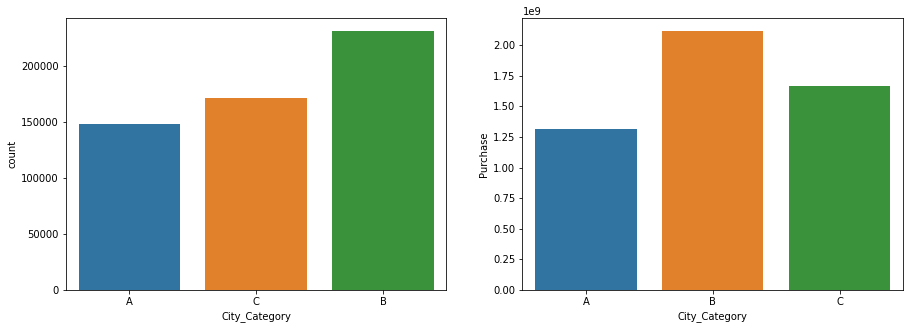

In [42]:
plt.subplots(figsize=(15,5))
plt.subplot(1, 2, 1)
sns.countplot(x = df['City_Category'])

plt.subplot(1, 2, 2)
data = df.groupby('City_Category')['Purchase'].sum().reset_index()
sns.barplot(x = data['City_Category'], y = data['Purchase'])

### maximum customers are from city B

<AxesSubplot:xlabel='City_Category', ylabel='count'>

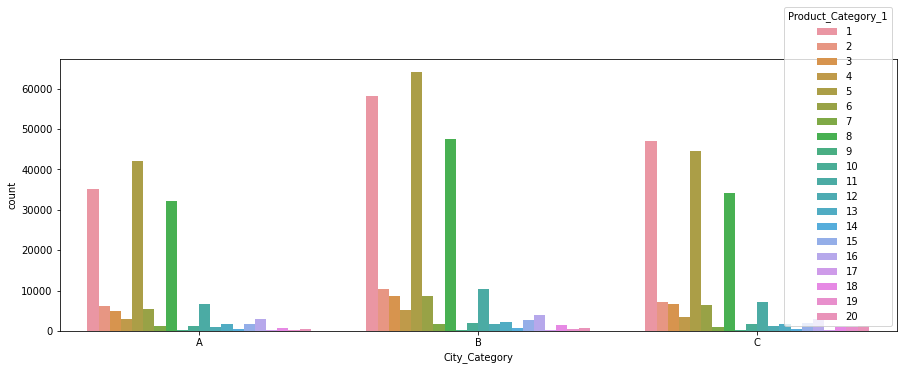

In [49]:
plt.subplots(figsize=(15,5))
data = df.groupby(['City_Category', 'Product_Category_1'])['Product_Category_1'].count().reset_index(name='count')
sns.barplot(x = data['City_Category'], y = data['count'], hue = data['Product_Category_1'])

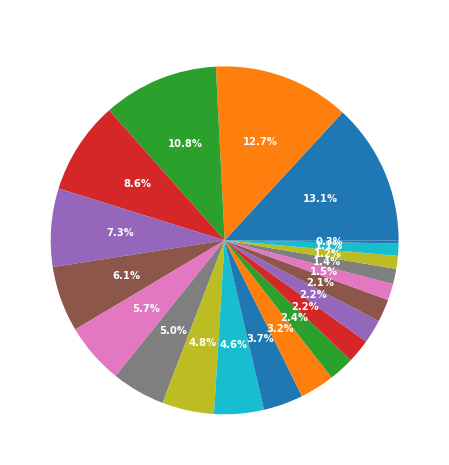

In [72]:
plt.subplots(figsize=(15,8))
plt.pie(df['Occupation'].value_counts().values, autopct='%1.1f%%', labels = df['Occupation'].value_counts().index, textprops={'color':"w", 'weight': 'bold'})
plt.title("Occupation among customers", color='w', weight="bold")
plt.show()

<AxesSubplot:xlabel='Occupation', ylabel='Purchase'>

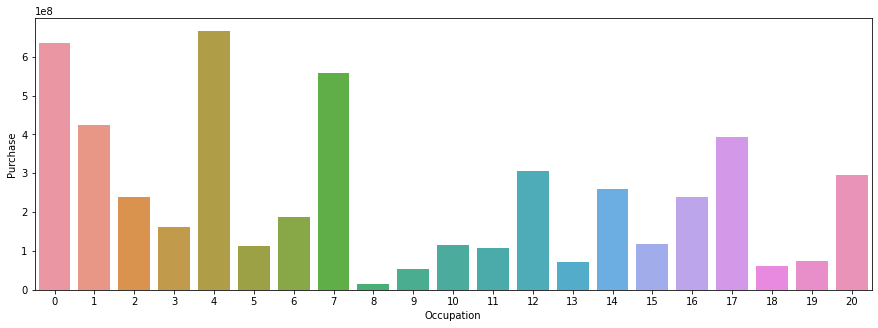

In [75]:
plt.subplots(figsize=(15,5))
data = df.groupby('Occupation')['Purchase'].sum().reset_index()
sns.barplot(x = data['Occupation'], y = data['Purchase'])

### customers with occupation 0, 4, 7, 12, 17 and 20 have high spendings
### since occupations 0, 4, 7 are in majority this trend is expected but for 17, 12 and 20 the spendings are relatively high

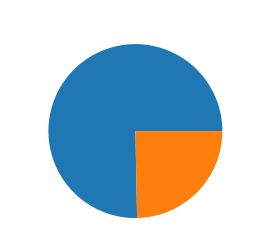

In [66]:
plt.pie(df['Gender'].value_counts().values, labels=['Male', 'Female'], textprops={'color':"w", 'weight': 'bold'})
plt.title("gender distribution among customers", color='w', weight="bold")
plt.show()

### since there are more no. of males, we can expect our model to be biased towards males

<AxesSubplot:xlabel='Gender', ylabel='Purchase'>

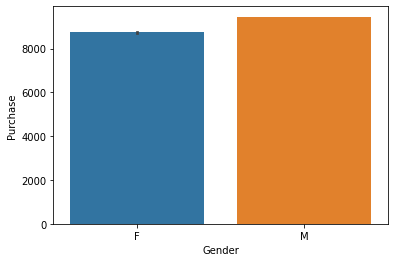

In [19]:
sns.barplot(x = df['Gender'], y = df['Purchase'])

<AxesSubplot:xlabel='Age', ylabel='count'>

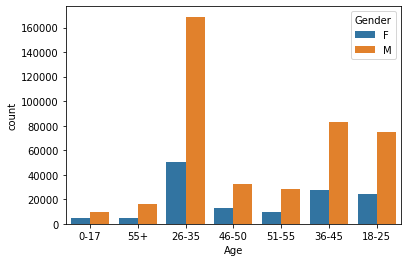

In [20]:
sns.countplot(x = df['Age'], hue = df['Gender'])

<AxesSubplot:xlabel='Age', ylabel='count'>

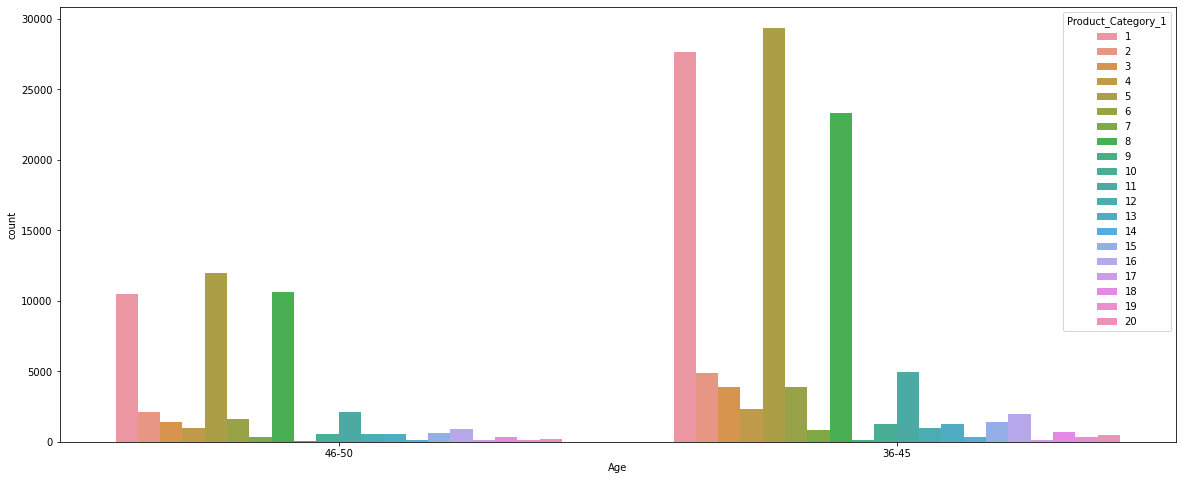

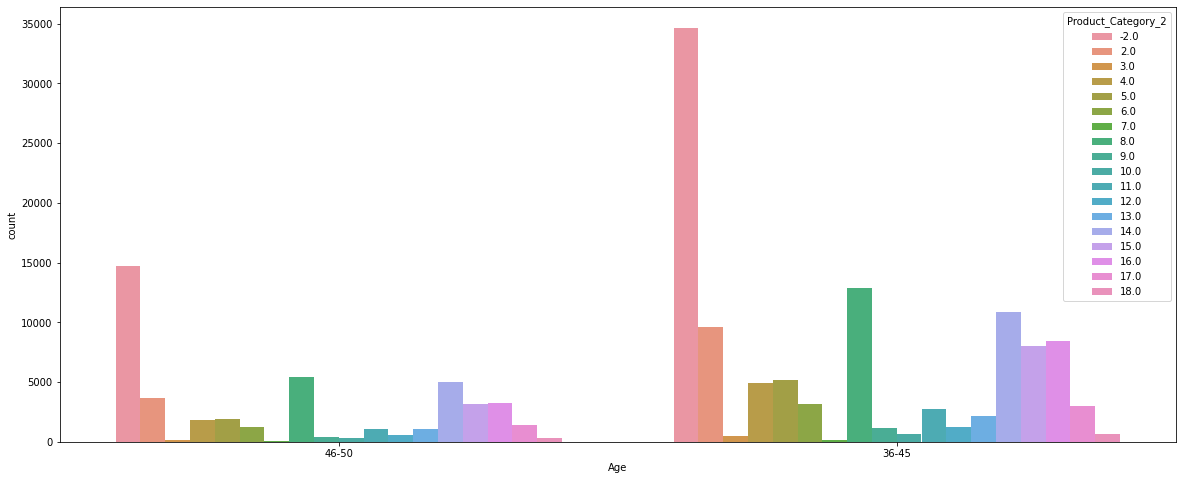

In [44]:
plt.subplots(figsize=(20,8))
age = df[(df['Age']=="46-50") | (df['Age']=="36-45")]
sns.countplot(x = age.Age, hue=df['Product_Category_1'])

plt.subplots(figsize=(20,8))
sns.countplot(x = age.Age, hue=df['Product_Category_2'])

### here we can see that the product distribution for both these age categories are same, hence we can merge these into 1 column so as to reduce the dimensionality of our data

In [169]:
df['Age'].replace(to_replace = "46-50", value = "36-45", inplace=True)
df['Age'].unique()

array(['0-17', '55+', '26-35', '36-45', '51-55', '18-25'], dtype=object)

In [51]:
df['City_Category'].value_counts()

B    231173
C    171175
A    147720
Name: City_Category, dtype: int64

In [170]:
le = LabelEncoder()
df['Gender'] = le.fit_transform(df['Gender'])
print(le.classes_)

df['City_Category'] = le.fit_transform(df['City_Category'])
print(le.classes_)

['F' 'M']
['A' 'B' 'C']


In [171]:
ohe = OneHotEncoder(drop='first')
data = ohe.fit_transform(df['Age'].values.reshape(-1, 1))
print(ohe.categories_)

[array(['0-17', '18-25', '26-35', '36-45', '51-55', '55+'], dtype=object)]


In [172]:
df.drop('Age', axis = 1, inplace = True)
df = pd.concat([df, pd.DataFrame(data.toarray(), columns=['18-25', '26-35', '36-45', '51-55', '55+'])], axis = 1)

In [173]:
df.drop(['User_ID', 'Product_ID'], axis = 1, inplace = True)
df.head()

,Gender,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase,18-25,26-35,36-45,51-55,55+
0,0,10,0,2,0,3,-2.0,-2.0,8370,0.0,0.0,0.0,0.0,0.0
1,0,10,0,2,0,1,6.0,14.0,15200,0.0,0.0,0.0,0.0,0.0
2,0,10,0,2,0,12,-2.0,-2.0,1422,0.0,0.0,0.0,0.0,0.0
3,0,10,0,2,0,12,14.0,-2.0,1057,0.0,0.0,0.0,0.0,0.0
4,1,16,2,4+,0,8,-2.0,-2.0,7969,0.0,0.0,0.0,0.0,1.0


In [174]:
df['Stay_In_Current_City_Years'] = df['Stay_In_Current_City_Years'].apply(lambda x : int(x.strip("+")))

In [104]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 14 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Gender                      550068 non-null  int32  
 1   Occupation                  550068 non-null  int64  
 2   City_Category               550068 non-null  int32  
 3   Stay_In_Current_City_Years  550068 non-null  int64  
 4   Marital_Status              550068 non-null  int64  
 5   Product_Category_1          550068 non-null  int64  
 6   Product_Category_2          550068 non-null  float64
 7   Product_Category_3          550068 non-null  float64
 8   Purchase                    550068 non-null  int64  
 9   18-25                       550068 non-null  float64
 10  26-35                       550068 non-null  float64
 11  36-45                       550068 non-null  float64
 12  51-55                       550068 non-null  float64
 13  55+           

<a id='pipeline'></a>
# combining preprocessing steps into a pipeline

In [9]:
class AgeEncoder(BaseEstimator, TransformerMixin):
    def fit(self, X, y = None, *args):
        return self
    
    def transform(self, X, y = None, *args):
        X['Age'] = X['Age'].replace(to_replace = "46-50", value = "36-45")
        ohe = OneHotEncoder(drop='first')
        data = ohe.fit_transform(X['Age'].values.reshape(-1, 1))
        X = X.drop('Age', axis = 1)
        X = pd.concat([X, pd.DataFrame(data.toarray(), columns=['18-25', '26-35', '36-45', '51-55', '55+'])], axis = 1)
        return X

class CustomImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y = None, *args):
        return self
    
    def transform(self, X, y = None, *args):
        X[['Product_Category_2', 'Product_Category_3']] = X[['Product_Category_2', 'Product_Category_3']].fillna(-2)
        return X

class CustomEncoder(BaseEstimator, TransformerMixin):
    def fit(self, X, y = None, *args):
        return self
    
    def transform(self, X, y = None, *args):
        le = LabelEncoder()
        X['Gender'] = le.fit_transform(X['Gender'])
        np.save('datasets/blackFriday/gender_classes.npy', le.classes_)

        X['City_Category'] = le.fit_transform(X['City_Category'])
        np.save('datasets/blackFriday/city_classes.npy', le.classes_)
        return X

def convertInt(X, *args):
    X['Stay_In_Current_City_Years'] = X['Stay_In_Current_City_Years'].apply(lambda x : int(x.strip("+")))
    return X

train = ColumnTransformer(transformers=[
    ("age", AgeEncoder(), ['Age', 'Marital_Status', 'Occupation']),
    ('CustomEncode', CustomEncoder(), ['Gender', 'City_Category']),
    ('impute', CustomImputer(), ['Product_Category_1', 'Product_Category_2', 'Product_Category_3']),
    ('stay', FunctionTransformer(convertInt), ['Stay_In_Current_City_Years'] ),
])

df = pd.read_csv('datasets/blackFriday/train.csv')
X = df.drop('Purchase', axis=1)
y = df['Purchase']

X = train.fit_transform(X)

In [36]:
class TestEncoder(BaseEstimator, TransformerMixin):
    def fit(self, X, y = None, *args):
        return self
    
    def transform(self, X, y = None, *args):
        le = LabelEncoder()
        le.classes_ = np.load('datasets/blackFriday/gender_classes.npy', allow_pickle=True)
        X['Gender'] = le.transform(X['Gender'])
        le.classes_ = np.load('datasets/blackFriday/city_classes.npy', allow_pickle=True)
        X['City_Category'] = le.transform(X['City_Category'])
        return X

test = ColumnTransformer(transformers=[
    ("age", AgeEncoder(), ['Age', 'Marital_Status', 'Occupation']),
    ('genderEncode', TestEncoder(), ['Gender', 'City_Category']),
    ('impute', CustomImputer(), ['Product_Category_1', 'Product_Category_2', 'Product_Category_3']),
    ('stay', FunctionTransformer(convertInt), ['Stay_In_Current_City_Years'] ),
])

<a id='Regression'></a>
# Regression

In [18]:
model_list = [LinearRegression(), Ridge(), Lasso(), SGDRegressor(), DecisionTreeRegressor()]

In [19]:
for clf in model_list:
    print(clf, " mean score ", np.mean(cross_val_score(clf, X, y, cv=5, scoring='neg_mean_squared_error')), "\n")

LinearRegression()  mean score  -21387870.145714693 

Ridge()  mean score  -21387870.122517437 

Lasso()  mean score  -21388954.11736966 

SGDRegressor()  mean score  -21885265.055160612 

DecisionTreeRegressor()  mean score  -11093991.268751075 



In [27]:
rdf_clf = RandomForestRegressor(max_depth = 5, n_jobs=-1)
np.mean(cross_val_score(rdf_clf, X, y, cv=5, scoring='neg_mean_squared_error'))

-11729398.750218982

In [28]:
gd_clf = GradientBoostingRegressor()
np.mean(cross_val_score(gd_clf, X, y, cv=5, scoring='neg_mean_squared_error'))

-8966359.074184861

In [29]:
ad_clf = AdaBoostRegressor()
np.mean(cross_val_score(ad_clf, X, y, cv=3, scoring='neg_mean_squared_error'))

-13301111.417854903

### gradient boosting gives best results
let's fine tune it and train it finally on whole train dataset

In [31]:
# takes too long to run
gd_clf = GradientBoostingRegressor(n_estimators=200)
np.mean(cross_val_score(gd_clf, X, y, cv=5, scoring='neg_mean_squared_error'))

In [32]:
gd_clf = GradientBoostingRegressor()
gd_clf.fit(X, y)

GradientBoostingRegressor()

In [45]:
df_test = pd.read_csv('datasets/blackFriday/test.csv')
X_test = test.fit_transform(df_test)
y_test_preds = gd_clf.predict(X_test)

submission = pd.read_csv('datasets/blackFriday/sample_submission.csv')
submission['Purchase'] = y_test_preds
submission.to_csv('datasets/blackFriday/grad_submission.csv', index=False)

In [47]:
ds_reg = DecisionTreeRegressor()
ds_reg.fit(X, y)
y_ds_preds = ds_reg.predict(X_test)
submission['Purchase'] = y_ds_preds
submission.to_csv('datasets/blackFriday/des_submission.csv', index=False)

In [49]:
rdf_clf = RandomForestRegressor(max_depth = 5, n_jobs=-1)
rdf_clf.fit(X, y)
y_rdf_preds = rdf_clf.predict(X_test)
submission['Purchase'] = y_rdf_preds
submission.to_csv('datasets/blackFriday/rdf_submission.csv', index=False)

In [50]:
df = pd.read_csv('datasets/blackFriday/train.csv')

In [56]:
# dropping product category 2 and 3 as they contained large amount of nan values
train1 = ColumnTransformer(transformers=[
    ("age", AgeEncoder(), ['Age', 'Marital_Status', 'Occupation']),
    ('CustomEncode', CustomEncoder(), ['Gender', 'City_Category']),
    ('stay', FunctionTransformer(convertInt), ['Stay_In_Current_City_Years'] ),
], remainder='passthrough')
test1 = ColumnTransformer(transformers=[
    ("age", AgeEncoder(), ['Age', 'Marital_Status', 'Occupation']),
    ('genderEncode', TestEncoder(), ['Gender', 'City_Category']),
    ('stay', FunctionTransformer(convertInt), ['Stay_In_Current_City_Years'] ),
], remainder='passthrough')

X = df.drop(['Purchase', 'Product_Category_2', 'Product_Category_3', 'User_ID', 'Product_ID'], axis=1)
y = df['Purchase']
X = train1.fit_transform(X)

gd_clf = GradientBoostingRegressor()
gd_clf.fit(X, y)

df_test = pd.read_csv('datasets/blackFriday/test.csv')
df_test = df_test.drop(['Product_Category_2', 'Product_Category_3', 'User_ID', 'Product_ID'], axis=1)
X_test = test1.fit_transform(df_test)
y_test_preds = gd_clf.predict(X_test)

submission = pd.read_csv('datasets/blackFriday/sample_submission.csv')
submission['Purchase'] = y_test_preds
submission.to_csv('datasets/blackFriday/grad1_submission.csv', index=False)

### dropping doesn't increase the accuracy